------------
INSTRUCTIONS
------------

Run each cell from top to bottom. The final cell allows you to save the generated data after all other cells were executed. Running the final cell is not mandatory, do it only if you wish to save the data. The data will be saved to the folder where this code is stored.

If this is your first time running the code, type ctrl + F and then type r'C, this will take you to the parts of the code where an instruction to read a specific path in your computer is given. Make sure that the path exists in your computer and that it corresponds to the path where the file being specified can be found.

------------
DESCRIPTIONS
-------------

File type (PDB or CIF): The crystal structure file extension. Suggested value: PDB.

File name: The name of the file containing the crystal structure (do not include the extension).

Number of nodes: This output tells you how many nodes the elastic network will have. The number of nodes depends on the number of amino acid residues of the biomolecule (if it's heterogeneous in composition) or simply on the number of atoms of the biomolecule (if it's homogeneous in composition).

Calculate average node mass?: This can be useful to assign an average node mass to the elastic network model. Suggested value: yes.

Average node mass (Da): This output will appear if you chose to calculate the average node mass.

Minimum interatomic distance (angstroms): This output tells you the minimum distance between two nodes in the elastic network.

Average interatomic distance (angstroms): This output tells you the average distance between nodes in the elastic network.

Maximum interatomic distance (angstroms): This output tells you the maximum distance between two nodes in the elastic network.

Elastic constant model (variable or uniform): Variable means exponential decay model, uniform means heaviside step function.  Suggested value: uniform.

Elastic constant (N/m): If you decided to use a uniform elastic constant model, you will be asked to give the elastic constant a specific value. Suggested value: 1.

Cutoff distance (angstroms): Interaction between pairs of nodes will be limited to nodes separated by a distance less than or equal to the cutoff distance. By this point, the program will have shown you minimum, average, and maximum interatomic distances of the elastic network; use that information to decide. Suggested value: 12.

Mass model (variable or uniform): Variable means that you will input a file containing variable masses. Uniform means that you will input a single node mass. Suggested value: uniform.

Single node mass (Da): This will be asked if the mass model is uniform. Suggested value: 110.

Number of desired natural frequencies (from the lowest): Type "all" if you want all the available natural frequencies. Suggested value: "all" for small biomolecules (such as a protein), 50 or 100 for bigger biomolecules (such as entire viral capsids).

Graph molecule?: Type "yes" if you want to graph the molecule, "no" if otherwise. Suggested value: yes.

Molecule graph scaling factor: This is related to the size of the graph. A large number will result in a very small representation of the molecule. Suggested value: 1.

Show axes?: Type "yes" if you want to see the cartesian axes, "no" if otherwise. Suggested value: yes.

Draw bonds?: Type "yes" if you want bonds to be drawn between nodes, type "no" if otherwise. Drawing nodes will require more computation time. If you choose to draw the bonds, you will be asked to give a cutoff distance for the drawing. It would make sense to choose the same cutoff distance that you chose for the normal mode analysis. Suggested value: no.

Annotate nodes?: Type "yes" if you want each individual node of the elastic network to be annotated (alpha carbon atoms only), type "no" if otherwise. Suggested value: no.

Angle 1 (degrees): Graph angle. Suggested value: 0.

Angle 2 (degrees): Graph angle. Suggested value: 0.

Node size: How big do you want the nodes to be? Suggested value: 20 to 50 for small biomolecules (such as a protein), 0.5 or 1 for bigger biomolecules (such as an entire viral capsid).

Computation time: The time it took your computer to perform all the calculations.
    
Eigenratio (approx. 0): This output corresponds to the negative eigenvalues to positive eigenvalues ratio. It should be approximately 0.

Unstable modes (approx. 0): This output is the percentage of negative eigenvalues with respect to all eigenvalues. A negative eigenvalue corresponds to what is known as an unstable mode. It should be approximately 0.

Unstable eigenvalues (negative zeroes): This output is a vector containing the negative eigenvalues. It should contain negative zeroes (very small negative numbers).

Negative eigenvalues (small): This output is the size of the vector showing the negative eigenvalues. In other words, the number of negative eigenvalues or unstable modes found. It should be small compared to the number of total eigenvalues.

In [1]:
# LIBRARIES, FUNCTIONS AND INITILIZATION

# Libraries
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import scipy.linalg as la
from pathlib import Path
import matplotlib as mp
import pandas as pd
import numpy as np
import time
import math
import os

# Round scientific notation numbers
def to_precision(x,p):
    x = float(x)
    if x == 0.:
        return "0." + "0"*(p-1)
    out = []
    if x < 0:
        out.append("-")
        x = -x
    e = int(math.log10(x))
    tens = math.pow(10, e - p + 1)
    n = math.floor(x/tens)
    if n < math.pow(10, p - 1):
        e = e -1
        tens = math.pow(10, e - p+1)
        n = math.floor(x / tens)
    if abs((n + 1.) * tens - x) <= abs(n * tens -x):
        n = n + 1
    if n >= math.pow(10,p):
        n = n / 10.
        e = e + 1
    m = "%.*g" % (p, n)
    if e < -2 or e >= p:
        out.append(m[0])
        if p > 1:
            out.append(".")
            out.extend(m[1:p])
        out.append('e')
        if e > 0:
            out.append("+")
        out.append(str(e))
    elif e == (p -1):
        out.append(m)
    elif e >= 0:
        out.append(m[:e+1])
        if e+1 < len(m):
            out.append(".")
            out.extend(m[e+1:])
    else:
        out.append("0.")
        out.extend(["0"]*-(e+1))
        out.append(m)
    return "".join(out)

# Integer validation
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        pass
    try:
        import unicodedata
        unicodedata.numeric(s)
        return True
    except (TypeError, ValueError):
        pass
    return False

# String substraction
def substract(a, b):                              
    return "".join(a.rsplit(b))

# List of average masses of all alpha amino acids
Residues = []
Residues.append([57.052, 'GLY'])
Residues.append([71.079, 'ALA'])
Residues.append([87.078, 'SER'])
Residues.append([97.117, 'PRO'])
Residues.append([99.133, 'VAL'])
Residues.append([101.105, 'THR'])
Residues.append([103.144, 'CYS'])
Residues.append([113.160, 'ILE'])
Residues.append([113.160, 'LEU'])
Residues.append([114.104, 'ASN'])
Residues.append([115.089, 'ASP'])
Residues.append([128.131, 'GLN'])
Residues.append([128.174, 'LYS'])
Residues.append([129.116, 'GLU'])
Residues.append([131.198, 'MET'])
Residues.append([137.142, 'HIS'])
Residues.append([147.177, 'PHE'])
Residues.append([156.188, 'ARG'])
Residues.append([163.170, 'TYR'])
Residues.append([186.213, 'TRP'])
dfMass = pd.DataFrame({'Mass': np.transpose(Residues)[0], 'Residue': np.transpose(Residues)[1]}) # Convert to dataframe

File type (PDB or CIF): PDB
File name: 5WB0
Number of nodes:  1326
Coarse-graining level (conventional or ultra): conventional
Calculate average node mass?: no
Minimum interatomic distance (angstroms): 3.759
Average interatomic distance (angstroms): 41.233
Maximum interatomic distance (angstroms): 98.54
Elastic constant model (variable or uniform): variable
Cutoff distance (angstroms): 20
Mass model (variable or uniform): variable
Number of desired natural frequencies (from the lowest): 100
Graph molecule? yes
Molecule graph scaling factor: 1.5
Show axes? yes
Draw bonds? no
Annotate nodes? no
Angle 1 (degrees): 0
Angle 2 (degrees): 0
Node size: 1
Computation time: 147.8356 s

                                        Result
Eigenratio (approx. 0)                       0
Unstable modes (approx. 0)                1.0%
Unstable eigenvalues (negative zeroes)  [-0.0]
Negative eigenvalues (small)                 1


<IPython.core.display.Javascript object>


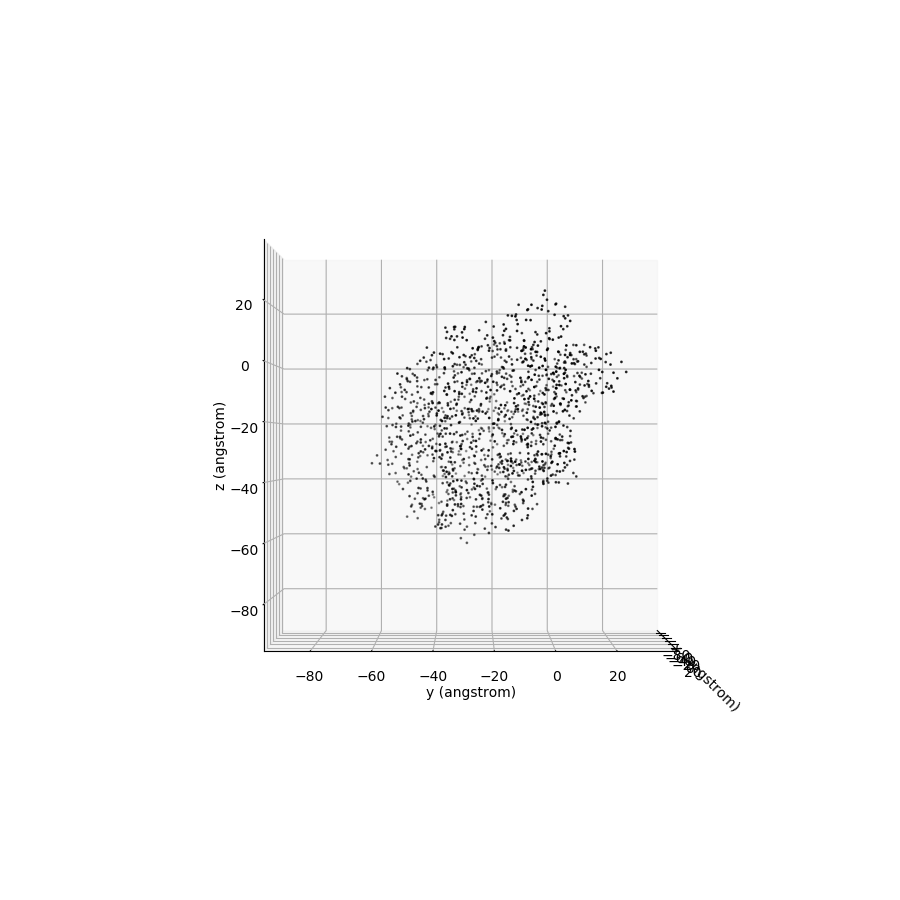

<IPython.core.display.Javascript object>


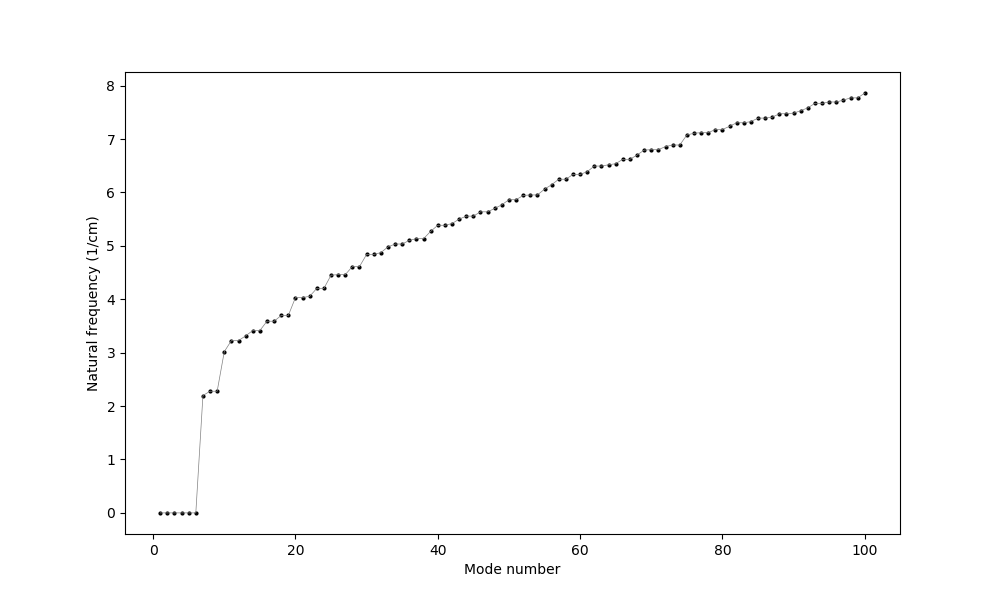

In [5]:
# NORMAL MODE ANALYSIS

# File type
FileType = 0
while FileType == 0:
    FileType = input('\033[1m' + 'File type (PDB or CIF): ' + '\033[0')
    if FileType not in {'PDB', 'CIF'}:
        FileType = 0
        print('Invalid file type')
    elif FileType in {'PDB', 'CIF'}:
        FileType = str(FileType)
        
# File directory
FileName = 0
boolx = False
while FileName == 0:
    path = 0
    FileName = input('\033[1m' + 'File name: ' + '\033[0')
    if FileName.startswith('C') == True:
        boolx = True
    if boolx == True:
        MolChem = 'homogeneous'
    elif boolx == False:
        MolChem = 'heterogeneous'
    if FileType == 'PDB':
        FileName = FileName + '.pdb'
    elif FileType == 'CIF':
        FileName = FileName + '.cif'
    path  = os.path.join(r'C:\Users\santi\Desktop\2019\Biophysics\PDBs', FileName)
    if Path(path).is_file():
        if FileType == 'PDB':
            MoleculeName = substract(FileName,'.pdb')
        elif FileType == 'CIF':
            MoleculeName = substract(FileName,'.cif')
    else:
        FileName = 0
        print('File not found')
    
# Computation time
start_time = time.time()
        
# Number of nodes and list of all correspondent amino acids
N = 0
BiomoleculeResidues = []
with open(path) as file:
    for line in file:
        if line[:4] == 'ATOM':
            if MolChem == 'homogeneous':
                N += 1
            elif MolChem == 'heterogeneous':
                if FileType == 'PDB':
                    if line[13:15] == "CA":
                        N += 1
                        BiomoleculeResidues.append(line[17:20])
                elif FileType == 'CIF':
                    if line[15:17] == 'CA':
                        N += 1
                        BiomoleculeResidues.append(line[21:24])
file.closed
N = int(N)    
print('Number of nodes: ', N)
        
# Vector with all the corresponding masses for each amino acid in the biomolecule
if MolChem == 'heterogeneous':
    MassVector = np.zeros((N))
    for i in range(0, len(dfMass)):
        for j in range(0, N):
            if BiomoleculeResidues[j] == dfMass['Residue'][i]:
                MassVector[j] = dfMass['Mass'][i]
        # Replace zeroes in mass vector
        for j in range(0,N):
            if MassVector[j] == 0:
                MassVector[j] = 12.011 # Mass of a carbon atom
        
t1 = time.time()
    
# Coarse-graining level
if MolChem == 'homogeneous':  
    CoarseLevel = 'conventional'  
elif MolChem == 'heterogeneous': 
    CoarseLevel = 0
    if N < 1000: 
        CoarseLevel = 'conventional'
    elif N >= 1000: # Offer ultra-coarse-grained modeling only if the network has 1000 nodes or more
        while CoarseLevel == 0:  
            CoarseLevel = input('\033[1m' + 'Coarse-graining level (conventional or ultra): ' + '\033[0')  
            if CoarseLevel not in {'conventional', 'ultra'}:  
                CoarseLevel = 0  
                print('Elastic constant model must be either by carbons only (conventional) or by clumped carbons (ultra)')
                
# Average node mass
if CoarseLevel == 'conventional':
    if MolChem == 'heterogeneous':
        CalAvMass = 0
        while CalAvMass == 0:
            CalAvMass = input('\033[1m' + 'Calculate average node mass?: ' + '\033[0')
            if CalAvMass not in {'yes', 'no'}:
                CalAvMass = 0
                print('Answer must be yes or no')
            elif CalAvMass in {'yes', 'no'}:
                CalAvMass = str(CalAvMass)
    elif MolChem == 'homogeneous':
        CalAvMass = 'no'
else:
    CalAvMass = 'no'
    
t2 = time.time()

if CalAvMass == 'yes':
    AverageMass = 0
    MassSum = 0
    for i in range(0, N):
        MassSum = MassSum + MassVector[i]
    AverageMass = np.around(MassSum/N, 4)
    print('Average node mass (Da):', AverageMass)

# Conventional coarse-grained network
x0 = np.zeros((N))
y0 = np.zeros((N))
z0 = np.zeros((N))
counter = 0
with open(path) as file:
    for line in file:
        if line[:4] == 'ATOM':
            if MolChem == 'homogeneous':
                counter += 1
                x0[counter-1] = line[30:38]
                y0[counter-1] = line[38:46]
                z0[counter-1] = line[46:54]
            elif MolChem == 'heterogeneous':
                if FileType == 'PDB':
                    if line[13:15] == "CA":
                        counter += 1
                        x0[counter-1] = line[30:38]
                        y0[counter-1] = line[38:46]
                        z0[counter-1] = line[46:54]
                elif FileType == 'CIF':
                    if line[15:17] == 'CA':
                        counter += 1
                        x0[counter-1] = line[36:44]
                        y0[counter-1] = line[44:53]
                        z0[counter-1] = line[53:61]
file.closed

# Ultra-coarse-grained network
if CoarseLevel == 'ultra':
    # List with IDs of the residues (numbers)
    ResidueID = []
    with open(path) as file:
        for line in file:
            if line[:4] == 'ATOM':
                if FileType == 'PDB':
                    if line[13:15] == 'CA':
                        ResidueID.append(line[23:26])
                elif FileType == 'CIF':
                    if line[15:17] == 'CA':
                        ResidueID.append(line[31:34])
    file.closed
    # Boolean array comparing difference between CA residue IDs
    BResidueID = [int(ResidueID[i+1]) < int(ResidueID[i]) for i in range(len(ResidueID)-1)]
    # List with indices of chain switch (when next CA residue ID is less than the previous one)
    ChainSwitchIndex = []
    for i in range(0, len(BResidueID)):
        if BResidueID[i] == True:
            ChainSwitchIndex.append(i)
    # Center of mass of the proteins
    CAList = []
    for i in range(0, len(ChainSwitchIndex)):
        # First protein
        if i == 0:
            xCA = np.zeros((ChainSwitchIndex[i] + 1))
            yCA = np.zeros((len(xCA)))
            zCA = np.zeros((len(xCA)))
            for j in range(0, ChainSwitchIndex[i] + 1):
                xCA[j] = x0[j]
                yCA[j] = y0[j]
                zCA[j] = z0[j]
            # Coordinates of center of mass
            xSum = 0
            ySum = 0
            zSum = 0
            MassSum = 0
            for j in range(0, ChainSwitchIndex[i] + 1):
                xSum = xSum + MassVector[j]*xCA[j]
                ySum = ySum + MassVector[j]*yCA[j]
                zSum = zSum + MassVector[j]*zCA[j]
                MassSum = MassSum + MassVector[j]
            xCM = xSum/np.around(MassSum, 4)
            yCM = ySum/np.around(MassSum, 4)
            zCM = zSum/np.around(MassSum, 4)
            CAList.append([xCM, yCM, zCM, np.around(MassSum, 4)])
        # Other proteins (last one excluded)
        elif i != 0:
            xCA = np.zeros((ChainSwitchIndex[i] - ChainSwitchIndex[i-1]))
            yCA = np.zeros((len(xCA)))
            zCA = np.zeros((len(xCA)))
            for j in range(0, ChainSwitchIndex[i] - ChainSwitchIndex[i-1]):
                xCA[j] = x0[ChainSwitchIndex[i] - ChainSwitchIndex[0] + j]
                yCA[j] = y0[ChainSwitchIndex[i] - ChainSwitchIndex[0] + j]
                zCA[j] = z0[ChainSwitchIndex[i] - ChainSwitchIndex[0] + j]
            # Coordinates of center of mass
            xSum = 0
            ySum = 0
            zSum = 0
            MassSum = 0
            for j in range(0, ChainSwitchIndex[i] - ChainSwitchIndex[i-1]):
                xSum = xSum + MassVector[j]*xCA[j]
                ySum = ySum + MassVector[j]*yCA[j]
                zSum = zSum + MassVector[j]*zCA[j]
                MassSum = MassSum + MassVector[j]
            xCM = xSum/np.around(MassSum, 4)
            yCM = ySum/np.around(MassSum, 4)
            zCM = zSum/np.around(MassSum, 4)
            CAList.append([xCM, yCM, zCM, np.around(MassSum, 4)])
    # Last protein
    xCA = np.zeros((len(x0) - ChainSwitchIndex[len(ChainSwitchIndex) - 1] - 1))
    yCA = np.zeros((len(xCA)))
    zCA = np.zeros((len(xCA)))
    for i in range(0, len(x0) - ChainSwitchIndex[len(ChainSwitchIndex) - 1] - 1):
        xCA[i] = x0[ChainSwitchIndex[len(ChainSwitchIndex)-1] + 1 + i]
        yCA[i] = y0[ChainSwitchIndex[len(ChainSwitchIndex)-1] + 1 + i]
        zCA[i] = z0[ChainSwitchIndex[len(ChainSwitchIndex)-1] + 1 + i]
    # Coordinates of center of mass
    xSum = 0
    ySum = 0
    zSum = 0
    MassSum = 0
    for i in range(0, len(x0) - ChainSwitchIndex[len(ChainSwitchIndex) - 1] - 1):
        xSum = xSum + MassVector[i]*xCA[i]
        ySum = ySum + MassVector[i]*yCA[i]
        zSum = zSum + MassVector[i]*zCA[i]
        MassSum = MassSum + MassVector[i]
    xCM = xSum/np.around(MassSum, 4)
    yCM = ySum/np.around(MassSum, 4)
    zCM = zSum/np.around(MassSum, 4)
    CAList.append([xCM, yCM, zCM, np.around(MassSum)])
    N = len(CAList)
    HowMany = 3*N # Force number of desired natural frequencies to the full spectrum of the ultra-coarse-grained molecule
    # Ultra-coarse-grained position vectors, and masses
    x0Protein = np.zeros((N))
    y0Protein = np.zeros((N))
    z0Protein = np.zeros((N))
    MassVector = np.zeros((N))
    for i in range(0, N):
        x0Protein[i] = float(CAList[i][0])
        y0Protein[i] = float(CAList[i][1])
        z0Protein[i] = float(CAList[i][2])  
        MassVector[i] = float(CAList[i][3])
    print('Number of nodes: ' + str(N))

# Equillibrium interatomic distances matrix
d0 = np.zeros((N, N))
for i in range(0, N):
    for j in range(0, N):
        if i-j < 0:
            if CoarseLevel == 'conventional':
                d0[i,j] = np.sqrt((x0[i] - x0[j])**2 + (y0[i] - y0[j])**2 + (z0[i] - z0[j])**2)
            elif CoarseLevel == 'ultra':
                d0[i,j] = np.sqrt((x0Protein[i] - x0Protein[j])**2 + (y0Protein[i] - y0Protein[j])**2 + (z0Protein[i] - z0Protein[j])**2)
            d0[j,i] = d0[i,j]
d0Min = np.around(np.amin(d0[np.nonzero(d0)]), 3) # Minimum interatomic distance (ignoring zeroes in d0)
d0Sum = 0
for i in range(0, len(d0)): # Average interatomic distance (ignoring zeroes in d0)
    for j in range(0, len(d0)):
        d0Sum = d0Sum + d0[i,j]
d0Average = np.around(d0Sum/np.count_nonzero(d0), 3)
d0Max = np.around(np.amax(d0), 3)

t3 = time.time()

print('Minimum interatomic distance (angstroms): ' + str(d0Min))
print('Average interatomic distance (angstroms): ' + str(d0Average))
print('Maximum interatomic distance (angstroms): ' + str(d0Max))

# Elastic constant model
kModel = 0
while kModel == 0:
    kModel = input('\033[1m' + 'Elastic constant model (variable or uniform): ' + '\033[0')
    if kModel not in {'variable', 'uniform'}:
        kModel = 0
        print('Elastic constant model must be either variable or uniform')
if kModel == 'uniform':
    kValue = 0
    while kValue == 0:
        kValue = input('\033[1m' + 'Elastic constant (N/m): ' + '\033[0')
        if is_number(kValue) == True:
            if float(kValue) < 0:
                kValue = 0
                print('Must be positive')
            elif float(kValue) == 0:
                print('Elastic constant cannot be 0')
            else:
                kValue = float(kValue)
        else:
            kValue = 0
            print('Must be a number')
            
# Cutoff distance
CutoffDistance = 0
while CutoffDistance == 0:
    CutoffDistance = input('\033[1m' + 'Cutoff distance (angstroms): ' + '\033[0')
    if is_number(CutoffDistance) == True:
        if float(CutoffDistance) < 0:
            CutoffDistance = 0
            print('Must be positive')
        elif float(CutoffDistance) == 0:
            print('Cutoff distance cannot be zero')
        else:
            CutoffDistance = float(CutoffDistance)
    else:
        CutoffDistance = 0
        print('Must be a number')

# Mass model
if CoarseLevel == 'conventional' and MolChem == 'heterogeneous':
    MassModel = 0
    while MassModel == 0:
        MassModel= input('\033[1m' + 'Mass model (variable or uniform): ' + '\033[0')
        if MassModel not in {'variable', 'uniform'}:
            MassModel = 0
            print('Mass model must be either variable or uniform')  
        elif MassModel in {'variable', 'uniform'}:
            # Uniform mass model?
            if MassModel == 'uniform':
                mass = 0
                while mass == 0:
                    mass = input('\033[1m' + 'Single node mass (Da): ' + '\033[0')
                    if is_number(mass) == True:
                        if float(mass) < 0:
                            mass = 0
                            print('Must be positive')
                        elif float(mass) == 0:
                            print('Single node mass cannot be 0')
                        else:
                            mass = float(mass)
                            for i in range(0,N):
                                MassVector[i] = mass
                    else:
                        mass = 0
                        print('Must be a number')
    # Number of desired natural frequencies (from the lowest)
    HowMany = 0
    while HowMany == 0:
        HowMany = input('\033[1m' + 'Number of desired natural frequencies (from the lowest): ' + '\033[0')
        if str(HowMany) == 'all':
            HowMany = int(3*N)
        elif is_number(HowMany) == True:
            if float(HowMany) <= 0:
                HowMany = 0
                print('Must be positive')
            else:
                if (float(HowMany)).is_integer() == False:
                    HowMany = 0
                    print('Must be an integer')
                elif int(HowMany) >= 3*N + 1:
                    HowMany = 0
                    print('Number of desired natural frequencies must be less than ',str(3*N + 1))
                else:
                    HowMany = int(HowMany)
        else:
            HowMany = 0
            print('Must be a number or <all>')
if MolChem == 'homogeneous':
    HowMany = 3*N # Force number of desired natural frequencies to be the same as the full spectrum of the molecule
    mass = 0
    while mass == 0:
        mass = input('\033[1m' + 'Single node mass (Da): ' + '\033[0')
        if is_number(mass) == True:
            if float(mass) < 0:
                mass = 0
                print('Must be positive')
            elif float(mass) == 0:
                print('Single node mass cannot be 0')
            else:
                mass = float(mass)
                MassVector = np.zeros((N))
                for i in range(0,N):
                    MassVector[i] = mass
        else:
            mass = 0
            print('Must be a number') 
    
# Graph molecule?
Graph = 0
while Graph == 0:
    Graph = input('\033[1m' + 'Graph molecule? ' + '\033[0')
    if Graph not in ['yes', 'no']:
        Graph = 0
        print('Answer must be yes or no')
    
if Graph == 'yes':
    # Axes scaling factor
    ScalingFactor = 0
    while ScalingFactor == 0:
        ScalingFactor = input('\033[1m' + 'Molecule graph scaling factor: ' + '\033[0')
        if is_number(ScalingFactor) == True:
            if float(ScalingFactor) < 0:
                ScalingFactor = 0
                print('Must be positive')
            elif float(ScalingFactor) == 0:
                print('Scaling factor cannot be zero')
            else:
                ScalingFactor = float(ScalingFactor)
        else:
            ScalingFactor = 0
            print('Must be a number')
    
    # Ask if axes should be shown
    ShowAxes = 0
    while ShowAxes == 0:
        ShowAxes = input('\033[1m' + 'Show axes? ' + '\033[0')
        if ShowAxes not in ['yes', 'no']:
            ShowAxes = 0
            print('Answer must be yes or no')
    
    # Ask if bonds should be drawn
    DrawBonds = 0
    while DrawBonds == 0:
        DrawBonds = input('\033[1m' + 'Draw bonds? ' + '\033[0')
        if DrawBonds not in {'yes', 'no'}:
            DrawBonds = 0
            print('Answer must be yes or no')
        elif DrawBonds in {'yes', 'no'}:
            DrawBonds = str(DrawBonds)
    
    # Annotate points?
    Annotate = 0
    while Annotate == 0:
        Annotate = input('\033[1m' + 'Annotate nodes? ' + '\033[0')
        if Annotate not in {'yes', 'no'}:
            Annotate = 0
            print('Answer must be yes or no')
        elif Annotate in {'yes', 'no'}:
            Annotate = str(Annotate)
        
    # Initial angles
    Angle1 = -1
    Angle2 = -1
    while Angle1 == -1:
        Angle1 = input('\033[1m' + 'Angle 1 (degrees): ' + '\033[0')
        if is_number(Angle1) == True:
            if float(Angle1) < 0:
                Angle1 = -1
                print('Must be positive')
            elif float(Angle1) > 360:
                Angle1 = -1
                print('Cannot be greater than 360°')
            else:
                Angle1 = float(Angle1)
        else:
            Angle1 = -1
            print('Must be a number')
    while Angle2 == -1:
        Angle2 = input('\033[1m' + 'Angle 2 (degrees): ' + '\033[0')
        if is_number(Angle2) == True:
            if float(Angle2) < 0:
                Angle2 = -1
                print('Must be positive')
            elif float(Angle2) > 360:
                Angle2 = -1
                print('Cannot be greater than 360°')
            else:
                Angle2 = float(Angle2)
        else:
            Angle2 = -1
            print('Must be a number')
            
    if CoarseLevel == 'ultra':
        ShowBackbone = 0
        while ShowBackbone == 0:
            ShowBackbone = input('\033[1m' + 'Show backbone graph? ' + '\033[0')
            if ShowBackbone not in {'yes', 'no'}:
                ShowBackbone = 0
                print('Answer must be yes or no')
            elif ShowBackbone in {'yes', 'no'}:
                ShowBackbone = str(ShowBackbone)
    elif CoarseLevel == 'conventional':
        ShowBackbone = 'yes'
    
    # Backbone marker size
    if ShowBackbone == 'yes':
        MarkerSize = 0
        while MarkerSize == 0:
            MarkerSize = input('\033[1m' + 'Node size: ' + '\033[0')
            if is_number(MarkerSize) == True:
                if float(MarkerSize) < 0:
                    MarkerSize = 0
                    print('Must be positive')
                elif float(MarkerSize) == 0:
                    MarkerSize = 0
                    print('Cannot be zero')
                elif float(MarkerSize) > 25:
                    MarkerSize = 0
                    print('Cannot be greater than 25')
                else:
                    MarkerSize = float(MarkerSize)
            else:
                MarkerSize = 0
                print('Must be a number')
    # Ultra-coarse-grained backbone marker size
    if CoarseLevel == 'ultra':
        MarkerSize2 = 0
        while MarkerSize2 == -0:
            MarkerSize2 = input('\033[1m' + 'Node size: ' + '\033[0')
            if is_number(MarkerSize2) == True:
                if float(MarkerSize2) < 0:
                    MarkerSize2 = 0
                    print('Must be positive')
                elif float(MarkerSize2) == 0:
                    MarkerSize2 = 0
                    print('Cannot be zero')
                elif float(MarkerSize2) > 200:
                    MarkerSize2 = 0
                    print('Cannot be greater than 200')
                else:
                    MarkerSize2 = float(MarkerSize2)
            else:
                MarkerSize2 = 0
                print('Must be a number')

t4 = time.time()

# Hessian matrix
k = np.zeros((N,N))
for i in range(0,N):
    for j in range(0,N):
        if i-j<0:
            if d0[i,j] < CutoffDistance:
                if kModel == 'variable':
                    if CoarseLevel == 'conventional':
                        k[i,j] = np.exp(-(d0[i,j]/7)**2) # Exponential decay model for small interatomic distances
                    elif CoarseLevel == 'ultra':
                        k[i,j] = np.exp(-(d0[i,j]/70)**2) # Exponential decay model for big interatomic distances
                elif kModel == 'uniform':
                    k[i,j] = kValue
            k[j,i] = k[i,j]
            
# Dynamic matrix    
D = np.zeros((3*N,3*N))
Dsum = np.zeros((N))
# I. Case alpha == beta and i, j < N
for i in range(0,N):
    for j in range(0,N):
        if i!=j:
            D[i,j] = -k[i,j]*((x0[i]-x0[j])**2/(np.sqrt(MassVector[i]*MassVector[j])*(d0[i,j])**2))
for i in range(0,N):
    for j in range(0,N):
        Dsum[i] = Dsum[i] + np.sqrt(MassVector[j])*D[i,j]
for i in range(0,N):
    for j in range(0,N):
        if i==j:
            D[i,j] = -Dsum[i]/np.sqrt(MassVector[i])
Dsum.fill(0)
# II. Case alpha != beta, i < N and N < j < 2N
for i in range(0,N):
    for j in range(N,2*N):
        if j-i!=N:
            D[i,j] = -k[i,j-N]*(((x0[i]-x0[j-N])*(y0[i]-y0[j-N]))/(np.sqrt(MassVector[i]*MassVector[j-N])*(d0[i,j-N])**2))
for i in range(0,N):
    for j in range(N,2*N):
        Dsum[i] = Dsum[i] + np.sqrt(MassVector[j-N])*D[i,j]
for i in range(0,N):
    for j in range(N,2*N):
        if j-i==N:
            D[i,j] = -Dsum[i]/np.sqrt(MassVector[i])
Dsum.fill(0)
# III. Case alpha != beta, i < N and j > 2N
for i in range(0,N):
    for j in range(2*N,3*N):
        if j-i!=2*N:
           D[i,j] = -k[i,j-2*N]*(((x0[i]-x0[j-2*N])*(z0[i]-z0[j-2*N]))/(np.sqrt(MassVector[i]*MassVector[j-2*N])*(d0[i,j-2*N])**2))
for i in range(0,N):
    for j in range(2*N,3*N):
        Dsum[i] = Dsum[i] + np.sqrt(MassVector[j-2*N])*D[i,j]
for i in range(0,N):
    for j in range(2*N,3*N):
        if j-i==2*N:
            D[i,j] = -Dsum[i]/np.sqrt(MassVector[i])
Dsum.fill(0)
# IV. Case alpha != beta, N < i < 2N and j < N
for i in range(N,2*N):
    for j in range(0,N):
        D[i,j] = D[j,i]
# V. Case alpha == beta and N < i, j < 2N
for i in range(N,2*N):
    for j in range(N,2*N):
        if i!=j:
            D[i,j] = -k[i-N,j-N]*((y0[i-N]-y0[j-N])**2/(np.sqrt(MassVector[i-N]*MassVector[j-N])*(d0[i-N,j-N])**2))
for i in range(N,2*N):
    for j in range(N,2*N):
        Dsum[i-N] = Dsum[i-N] + np.sqrt(MassVector[j-N])*D[i,j]
for i in range(N,2*N):
    for j in range(N,2*N):
        if i==j:
            D[i,j] = -Dsum[i-N]/np.sqrt(MassVector[i-N])
Dsum.fill(0)
# VI. Case alpha != beta, N < i < 2N and j > 2N
for i in range(N,2*N):
    for j in range(2*N,3*N):
        if j-i!=N:
             D[i,j] = -k[i-N,j-2*N]*((y0[i-N]-y0[j-2*N])*((z0[i-N]-z0[j-2*N])/(np.sqrt(MassVector[i-N]*MassVector[j-2*N])*(d0[i-N,j-2*N])**2)))
for i in range(N,2*N):
    for j in range(2*N,3*N):
        Dsum[i-N] = Dsum[i-N] + np.sqrt(MassVector[j-2*N])*D[i,j]
for i in range(N,2*N):
    for j in range(2*N,3*N):
        if j-i==N:
            D[i,j] = -Dsum[i-N]/np.sqrt(MassVector[i-N])
Dsum.fill(0)
# VII. Case alpha != beta, i > 2N and j < N
for i in range(2*N,3*N):
    for j in range(0,N):
        D[i,j] = D[j,i]
# VIII. Case alpha != beta, i > 2N and N < j < 2N
for i in range(2*N,3*N):
    for j in range(N,2*N):
        D[i,j] = D[j,i]
# IX. Case alpha == beta, i > 2N and j > 2N
for i in range(2*N,3*N):
    for j in range(2*N,3*N):
        if i!=j:
            D[i,j] = -k[i-2*N,j-2*N]*((z0[i-2*N]-z0[j-2*N])**2/(np.sqrt(MassVector[i-2*N]*MassVector[j-2*N])*(d0[i-2*N,j-2*N])**2))
for i in range(2*N,3*N):
    for j in range(2*N,3*N):
        Dsum[i-2*N] = Dsum[i-2*N] + np.sqrt(MassVector[j-2*N])*D[i,j]
for i in range(2*N,3*N):
    for j in range(2*N,3*N):
        if i==j:
            D[i,j] = -Dsum[i-2*N]/np.sqrt(MassVector[i-2*N])
            
# Normal mode analysis
NegEV = 0
NegEigenSum = 0
PosEigenSum = 0
EigenRatio = 0
NegEigenPercentage = 0
AngularFrequencies = np.zeros((HowMany))
Frequencies = np.zeros((HowMany))
Wavenumbers = np.zeros((HowMany))
Eigenvalues, Eigenvectors = la.eigh(D, eigvals = (0, HowMany-1))
# Number of negative eigenvalues
for i in range(0, len(Eigenvalues)):
    if Eigenvalues[i] < 0:
        NegEV += 1
# Array containing the negative eigenvalues
UnstableModes = np.zeros((NegEV))
for i in range(0, NegEV):
    UnstableModes[i] = Eigenvalues[i]
    Eigenvalues[i] = 0 # Erase negative eigenvalues from original array
# Replace first six eigenvalues by zeroes
for i in range(0, 6):
    if Eigenvalues[i] != 0:
        Eigenvalues[i] = 0
# Average of negative eigenvalues and positive eigenvalues (for comparison purposes)
if NegEV != 0:
    for i in range(0, len(UnstableModes)):
        NegEigenSum = NegEigenSum + np.abs(UnstableModes[i])
    NegEigenAverage = NegEigenSum/len(UnstableModes)
    for i in range(len(Eigenvalues)-NegEV):
        PosEigenSum = PosEigenSum + Eigenvalues[NegEV+i]
    PosEigenAverage = PosEigenSum/(len(Eigenvalues)-NegEV)
    EigenRatio = NegEigenAverage/PosEigenAverage
    NegEigenPercentage = np.around(NegEV/len(Eigenvalues), 4)
# Convert eigenvalues from (rad N m^-1 Da^-1)^2 to (rad s^-1)^2, and calculate equivalent quantities
for i in range(0, HowMany):
    Eigenvalues[i] = float(to_precision(Eigenvalues[i], 4))
    Eigenvalues[i] = float(to_precision((Eigenvalues[i]/(1.660539*10**(-27))), 4))
    AngularFrequencies[i] = float(to_precision((np.sqrt(Eigenvalues[i])), 4))
    Frequencies[i] = float(to_precision(np.sqrt(Eigenvalues[i])/(2*np.around(np.pi,4)), 4))
    Wavenumbers[i] = float(to_precision(np.sqrt(Eigenvalues[i])/(2*np.around(np.pi,4)*2.99*10**10), 4))

# Record time
ComputationTime = np.around((time.time() - (start_time + (t2 - t1) + (t4 - t3))), 4)

# --------------------------------------------------------------------------------------------------------------------------

# List with basic results (save)
List = []
List.append(str(d0Min))
List.append(d0Average)
List.append(d0Max)
List.append(np.around(EigenRatio, 4))
List.append(str(np.around(NegEigenPercentage*100,4)) + '%')
List.append(np.around(UnstableModes, 4))
List.append(NegEV)
List.append(ComputationTime)
# Create dataframe for basic results
df = pd.DataFrame({'Result': List})
df.index = ['Minimun interatomic distance (angstroms)', 'Average interatomic distance (angstroms)', 'Maximum interatomic distance (angstroms)', 'Unstable to stable modes average eigenvalue ratio', 'Unstable modes percentage (with respect to calculated modes)', 'Unstable eigenvalues array', 'Number of negative eigenvalues', 'Computation time (s)']
print('Computation time: ' + str(ComputationTime) + ' s')

# List with basic results (print)
Listx = []
Listx.append(np.around(EigenRatio, 4))
Listx.append(str(np.around(NegEigenPercentage*100,4)) + '%')
Listx.append(np.around(UnstableModes, 4))
Listx.append(NegEV)
# Create dataframe for basic results
dfx = pd.DataFrame({'Result': Listx})
dfx.index = ['Eigenratio (approx. 0)', 'Unstable modes (approx. 0)', 'Unstable eigenvalues (negative zeroes)', 'Negative eigenvalues (small)']
print('')
print(dfx)

# Enable dynamic graphs mode
%matplotlib nbagg

# Graph
mp.rcParams.update({'font.size': 10})
i = np.arange(1, len(Eigenvalues) + 1, 1)
if Graph == 'yes':
    xmin = np.amin(x0)
    xmax = np.amax(x0)
    ymin = np.amin(y0)
    ymax = np.amax(y0)
    zmin = np.amin(z0)
    zmax = np.amax(z0)
    if ShowBackbone == 'yes':
        # CA backbone graph
        fig1 = plt.figure(figsize = (9, 9))
        ax1 = fig1.add_subplot(111, projection = '3d')
        if DrawBonds == 'yes' and CoarseLevel == 'conventional':
            for u in range(0,N):
                for j in range (0,N):
                    if k[u,j] != 0:
                        ax1.plot3D([x0[j], x0[u]], [y0[j], y0[u]], [z0[j], z0[u]], c = 'gray', linewidth = 0.1, linestyle = '-')
        ax1.scatter(x0, y0, z0, c = 'black', s = MarkerSize, marker = 'o')
        ax1.view_init(Angle1, Angle2) # Initial angle
        if ShowAxes == 'no':
            ax1.set_axis_off()
        # x-axis parameters
        ax1.set_xlabel('x (angstrom)')
        if xmin < 0 and xmax < 0:
            ax1.set_xlim(ScalingFactor*xmin, -ScalingFactor*xmax)
        if xmin < 0 and xmax > 0:
            ax1.set_xlim(ScalingFactor*xmin, ScalingFactor*xmax)
        if xmin > 0 and xmax > 0:
            ax1.set_xlim(-ScalingFactor*xmin, ScalingFactor*xmax)
        # y-axis parameters
        ax1.set_ylabel('y (angstrom)')
        if ymin < 0 and ymax < 0:
            ax1.set_ylim(ScalingFactor*ymin, -ScalingFactor*ymax)
        if ymin < 0 and ymax > 0:
            ax1.set_ylim(ScalingFactor*ymin, ScalingFactor*ymax)
        if ymin > 0 and ymax > 0:
            ax1.set_ylim(-ScalingFactor*ymin, ScalingFactor*ymax)
        # z-axis parameters
        ax1.set_zlabel('z (angstrom)')
        if zmin < 0 and zmax < 0:
            ax1.set_zlim(ScalingFactor*zmin, -ScalingFactor*zmax)
        if zmin < 0 and zmax > 0:
            ax1.set_zlim(ScalingFactor*zmin, ScalingFactor*zmax)
        if zmin > 0 and zmax > 0:
            ax1.set_zlim(-ScalingFactor*zmin, ScalingFactor*zmax)
        if Annotate == 'yes' and CoarseLevel == 'conventional':
            AtomNumber = np.arange(1, N + 1, 1)
            for x, y, z, AtomNumber in zip(x0, y0, z0, AtomNumber):
                label = '%d' % (AtomNumber)
                ax1.text(x, y, z, label, fontsize = 10, color = 'blue')
        plt.show()
        
    # Coarsed CA backbone graph
    if CoarseLevel == 'ultra':
        fig2 = plt.figure(figsize = (9, 9))
        ax2 = fig2.add_subplot(111, projection = '3d')
        if DrawBonds == 'yes':
            for u in range(0,N):
                for j in range (0,N):
                    if k[u,j] != 0:
                        ax2.plot3D([x0Protein[j], x0Protein[u]], [y0Protein[j], y0Protein[u]], [z0Protein[j], z0Protein[u]], c = 'gray', linewidth = 0.5, linestyle = '-')
        ax2.scatter(x0Protein, y0Protein, z0Protein, c = 'black', s = MarkerSize2, marker = 'o')
        ax2.view_init(Angle1, Angle2) # Initial angle
        if ShowAxes == 'no':
            ax2.set_axis_off()
        # x-axis parameters
        ax2.set_xlabel('x (angstrom)')
        xminProtein = np.amin(x0Protein)
        xmaxProtein = np.amax(x0Protein)
        if xmin < 0 and xmax < 0:
            ax2.set_xlim(ScalingFactor*xminProtein, -ScalingFactor*xmaxProtein)
        if xmin < 0 and xmax > 0:
            ax2.set_xlim(ScalingFactor*xminProtein, ScalingFactor*xmaxProtein)
        if xmin > 0 and xmax > 0:
            ax2.set_xlim(-ScalingFactor*xminProtein, ScalingFactor*xmaxProtein)
        # y-axis parameters
        ax2.set_ylabel('y (angstrom)')
        yminProtein = np.amin(y0Protein)
        ymaxProtein = np.amax(y0Protein)
        if ymin < 0 and ymax < 0:
            ax2.set_ylim(ScalingFactor*yminProtein, -ScalingFactor*ymaxProtein)
        if ymin < 0 and ymax > 0:
            ax2.set_ylim(ScalingFactor*yminProtein, ScalingFactor*ymaxProtein)
        if ymin > 0 and ymax > 0:
            ax2.set_ylim(-ScalingFactor*yminProtein, ScalingFactor*ymaxProtein)
        # z-axis parameters
        ax2.set_zlabel('z (angstrom)')
        zminProtein = np.amin(z0Protein)
        zmaxProtein = np.amax(z0Protein)
        if zmin < 0 and zmax < 0:
            ax2.set_zlim(ScalingFactor*zminProtein, -ScalingFactor*zmaxProtein)
        if zmin < 0 and zmax > 0:
            ax2.set_zlim(ScalingFactor*zminProtein, ScalingFactor*zmaxProtein)
        if zmin > 0 and zmax > 0:
            ax2.set_zlim(-ScalingFactor*zminProtein, ScalingFactor*zmaxProtein)
        if Annotate == 'yes':
            AtomNumber = np.arange(1, N + 1, 1)
            for x, y, z, AtomNumber in zip(x0Protein, y0Protein, z0Protein, AtomNumber):
                label = '%d' % (AtomNumber)
                ax2.text(x, y, z, label, fontsize = 10, color = 'blue')
        plt.show()
    
# Wavenumbers graph
fig3_size = plt.rcParams["figure.figsize"]
fig3_size[0] = 10
fig3_size[1] = 6
fig3, ax3 = plt.subplots()
ax3.set(xlabel = 'Mode number', ylabel = 'Natural frequency (1/cm)')
ax3.scatter(i, Wavenumbers, c = 'black', s = 4)
ax3.plot(i, Wavenumbers, c = 'gray', linewidth = 0.5, linestyle = '-')
plt.show()

# Eigenvalues dataframe
df1 = pd.DataFrame({'Eigenvalues (rad Hz)^2':Eigenvalues,'Angular frequency (rad Hz)':AngularFrequencies,'Frequency (Hz)':Frequencies,'Wavenumber (1/cm)':Wavenumbers})
df1.index = np.arange(1, len(df1) + 1)
df1.index.name = 'Mode number'

# Normal modes dataframe
df2 = pd.DataFrame(Eigenvectors)
df2.index = ['x' + str(i) for i in range(1, N + 1)] + ['y' + str(i) for i in range(1, N + 1)] + ['z' + str(i) for i in range(1, N + 1)]
df2.index.name = 'Coordinate'
df2.columns = np.arange(1, HowMany + 1)
df2.columns.name = 'Mode number'

# Coordinates dataframe
if CoarseLevel == 'conventional':
    df3 = pd.DataFrame({'x0': x0 ,'y0': y0, 'z0': z0})
elif CoarseLevel == 'ultra':
    df3 = pd.DataFrame({'x0': x0Protein ,'y0': y0Protein, 'z0': z0Protein})
df3.index = np.arange(1, len(df3) + 1)
    
# Masses dataframe
df4 = pd.DataFrame({'Masses (Da)': MassVector})
df4.index = np.arange(1, len(df4) + 1)
df4.index.name = 'Node'

In [6]:
# SAVE FILES

if MolChem == 'homogeneous':
    df3.to_csv(MoleculeName + '(homogeneous)_coordinates.csv')
    df4.to_csv(MoleculeName + '(homogeneous)_uniformMass_massVector.csv')
    if kModel == 'uniform': 
        df.to_csv(MoleculeName + '(homogeneous)_computationDetails_' + str(HowMany) + 'eigenvalues_cutoff' + str(CutoffDistance) + 'angstroms_k' + str(kValue) + 'Nm-1_mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
        df1.to_csv(MoleculeName + '(homogeneous)_' + str(HowMany) + 'eigenvalues_cutoff' + str(CutoffDistance) + 'angstroms_k' + str(kValue) + 'Nm-1_mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
        df2.to_csv(MoleculeName + '(homogeneous)_' + str(HowMany) + 'normalModes_cutoff' + str(CutoffDistance) + 'angstroms_k' + str(kValue) + 'Nm-1_mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
    elif kModel != 'uniform':   
        df.to_csv(MoleculeName + '(homogeneous)_computationDetails_' + str(HowMany) + 'eigenvalues_cutoff' + str(CutoffDistance) + 'angstroms_k' + kModel + '_mass' + str(np.around(np.average(MassVector), 4)) + '.csv')
        df1.to_csv(MoleculeName + '(homogeneous)_' + str(HowMany) + 'eigenvalues_cutoff' + str(CutoffDistance) + 'angstroms_k' + kModel + '_mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
        df2.to_csv(MoleculeName + '(homogeneous)_' + str(HowMany) + 'normalModes_cutoff' + str(CutoffDistance) + 'angstroms_k' + kModel + '_mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
elif MolChem == 'heterogeneous':
    if kModel == 'uniform':
        if CoarseLevel == 'conventional':
            df.to_csv(MoleculeName + '_CG_computationDetails_' + str(HowMany) + 'eigenvalues_cutoff' + str(CutoffDistance) + 'angstroms_k' + str(kValue) + 'Nm-1_mass' + MassModel + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df1.to_csv(MoleculeName + '_CG_' + str(HowMany) + 'eigenvalues_cutoff' + str(CutoffDistance) + 'angstroms_k' + str(kValue) + 'Nm-1_' + MassModel + 'Mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df2.to_csv(MoleculeName + '_CG_' + str(HowMany) + 'normalModes_cutoff' + str(CutoffDistance) + 'angstroms_k' + str(kValue) + 'Nm-1_' + MassModel + 'Mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df3.to_csv(MoleculeName + '_CG_coordinates.csv')
            df4.to_csv(MoleculeName + '_CG_' + str(MassModel) + 'Mass_massVector.csv')
        elif CoarseLevel == 'ultra':
            df.to_csv(MoleculeName + '_UCG_computationDetails_' + str(HowMany) + 'eigenvalues_cutoff' + str(CutoffDistance) + 'angstroms_k' + str(kValue) + 'Nm-1_uniformMass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df1.to_csv(MoleculeName + '_UCG_' + str(HowMany) + 'eigenvalues_cutoff' + str(CutoffDistance) + 'angstroms_k' + str(kValue) + 'Nm-1_uniformMass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df2.to_csv(MoleculeName + '_UCG_' + str(HowMany) + 'normalModes_cutoff' + str(CutoffDistance) + 'angstroms_k' + str(kValue) + 'Nm-1_uniformMass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df3.to_csv(MoleculeName + '_UCG_coordinates.csv')
            df4.to_csv(MoleculeName + '_UCG_uniformMass_massVector.csv')
    elif kModel != 'uniform':
        if CoarseLevel == 'conventional':
            df.to_csv(MoleculeName + '_CG_computationDetails_' + str(HowMany) + 'eigenvalues_cutoff' + str(CutoffDistance) + 'angstroms_k' + kModel + '_' + MassModel + 'Mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df1.to_csv(MoleculeName + '_CG_' + str(HowMany) + 'eigenvalues_cutoff' + str(CutoffDistance) + 'angstroms_k' + kModel + '_' + MassModel + 'Mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df2.to_csv(MoleculeName + '_CG_' + str(HowMany) + 'normalModes_cutoff' + str(CutoffDistance) + 'angstroms_k' + kModel + '_' + MassModel + 'Mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df3.to_csv(MoleculeName + '_CG_coordinates.csv')
            df4.to_csv(MoleculeName + '_CG_' + str(MassModel) + 'Mass_massVector.csv')
        elif CoarseLevel == 'ultra':
            df.to_csv(MoleculeName + '_UCG_computationDetails_' + str(HowMany) + 'eigenvalues_cutoff' + str(np.around(CutoffDistance,2)) + 'angstroms_k' + kModel + '_' + MassModel + 'mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df1.to_csv(MoleculeName + '_UCG_' + str(HowMany) + 'eigenvalues_cutoff' + str(np.around(CutoffDistance,2)) + 'angstroms_k' + kModel + '_' + MassModel + 'mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df2.to_csv(MoleculeName + '_UCG_' + str(HowMany) + 'normalModes_cutoff' + str(np.around(CutoffDistance,2)) + 'angstroms_k' + kModel + '_' + MassModel + 'mass' + str(np.around(np.average(MassVector), 4)) + 'Da.csv')
            df3.to_csv(MoleculeName + '_UCG_coordinates.csv')
            df4.to_csv(MoleculeName + '_UCG_uniformMass_massVector.csv')